### Import the libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Data ingestion

Here we specify the data source, download the data and read it into a DataFrame

In [2]:
url = 'https://introtomlsampledata.blob.core.windows.net/data/nyc-taxi/nyc-taxi-sample-data.csv'
response = requests.get(url)
raw_df = pd.read_csv(BytesIO(response.content))
raw_df.head()

,vendorID,passengerCount,tripDistance,hour_of_day,day_of_week,day_of_month,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount
0,1,1,9.40,15,2,27,1,None,False,29.058824,24.0,3.0,6.185714,44.30
1,2,5,14.75,13,4,15,1,None,False,0.000000,6.0,0.0,4.571930,44.80
2,2,1,3.35,23,4,8,1,None,False,0.000000,1.0,0.0,4.384091,18.96
3,2,1,3.33,18,2,27,1,None,False,29.058824,24.0,3.0,6.185714,16.30
4,2,1,0.47,17,6,3,1,None,False,0.000000,1.0,0.0,3.846429,5.30


### Data cleaning

Once we have read in the data we need to identify any non-numeric columns. In this case, we can simply drop them as we're just demonstrating the pipeline.

In [3]:
non_numeric_cols = [k for k,v in raw_df.dtypes.iteritems() if v not in ['int64','float64','bool']]
print(non_numeric_cols)
df = raw_df.drop(columns=non_numeric_cols)

['normalizeHolidayName']


### Data preparation

We split the data into a training set and a test set and identify the target and feature columns

In [4]:
train_df, test_df = train_test_split(df, train_size=0.7, random_state=42)
print(train_df.shape, test_df.shape)

y_col = 'totalAmount'
X_cols = df.drop(columns=y_col).columns.to_list()

train_X, train_y = train_df[X_cols], train_df[[y_col]]
test_X, test_y = test_df[X_cols], test_df[[y_col]]

(8213, 13) (3521, 13)


### Train model

Instantiate the model class and fit a model to the data

In [5]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Test model

Predict values for the test set and compare against the real values

In [6]:
pred_y = model.predict(test_X)

In [7]:
# root mean squared error
((pred_y-test_y)**2).mean()**0.5

totalAmount    3.652176
dtype: float64

In [8]:
# coefficient of determination (r-squared)
(
    (
        (test_y-test_y.mean()) * (pred_y-pred_y.mean())
    ).sum() / (
        len(test_y) * test_y.std() * pred_y.std()
    )
) ** 2

totalAmount    0.873455
dtype: float64

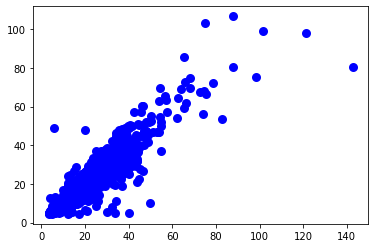

In [9]:
# predicted vs true chart
plt.scatter(test_y, pred_y, color='blue', linewidth=3)

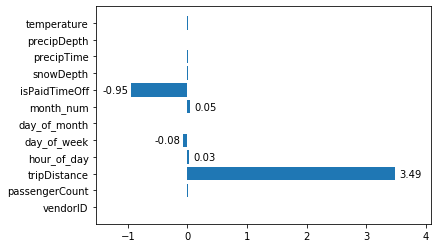

In [19]:
fig, ax = plt.subplots()

# plot the significance of each of the features
ax.barh(y=train_X.columns, width=model.coef_[0])

# add data labels
for rect in ax.patches:
    xpos = rect.get_width()                                     # horizontal position of the label
    ypos = rect.get_y() + rect.get_height()/2                   # vertical position of the label
    label = f'{xpos:0.2f}' if abs(xpos)>0.02 else ''            # only label larger coefficients to avoid clutter
    hpos = 15 if xpos > 0 else -15                              # label to the right if > 0, left if < 0
    ax.annotate(
        label, xy=(xpos,ypos), xytext=(hpos,-5),
        textcoords='offset points', ha='center', va='bottom'
    )

# scale up the axes by 15% to accommodate the labels
lim = np.array(ax.get_xlim())
mid = lim.mean()
new_lim = (lim - mid) * 1.15 + mid
ax.set_xlim(tuple(new_lim))

plt.show()